[Reference Paper for details](https://arxiv.org/pdf/1907.00503.pdf)

[Table Evaluator for GAN](https://github.com/Baukebrenninkmeijer/Table-Evaluator)

[ Date Time Transformer](https://sdv.dev/RDT/api/rdt.transformers.datetime.html)

In [1]:
import pandas as pd
!pip install ctgan
!pip install table_evaluator
!pip install rdt

     |████████████████████████████████| 9.5MB 11.8MB/s 
     |████████████████████████████████| 1.1MB 50.8MB/s 
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


  Created wheel for table-evaluator: filename=table_evaluator-1.2.2.post1-cp36-none-any.whl size=17055 sha256=c76fee651038aead5a2879b8dc684aac45c54b833fb70298665d2ce11b3de5da
  Stored in directory: /root/.cache/pip/wheels/a9/4d/9d/62b61486fc85b53ef9bf7979a52cda067a514c2a7a05c49bd4
Successfully built table-evaluator


In [1]:
# Accessing High Quality extracted Data uploaded on Drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fileId = '1T1QEiw1DXusEU-LTWtDWivDS_ZmQGg3c'
fileName = fileId
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile('Dataset_100_Patient.zip')

In [2]:
!unzip '/content/Dataset_100_Patient.zip' -d '/content/sample_data/Dataset'

Archive:  /content/Dataset_100_Patient.zip
  inflating: /content/sample_data/Dataset/Diagnosis.csv  
  inflating: /content/sample_data/Dataset/Prescriptions.csv  
  inflating: /content/sample_data/Dataset/Therapy.csv  
  inflating: /content/sample_data/Dataset/Vital_Signs.csv  


In [3]:
from table_evaluator import load_data, TableEvaluator # library used for Comparing Synthetic Data with Real Data 

In [4]:
from rdt.transformers import DatetimeTransformer 
transformer = DatetimeTransformer() # Object used to transform DateTime Columns to float values

In [5]:
from ctgan import CTGANSynthesizer 
import pandas as pd

- CTGAN model takes parameters as dataframe and names of discrete columns in dataset
- read_csv is used for reading csv and removing nan values if any
- read_categoricall processes the dataset and provides thelist of categorical columns list
- sample_list consist of all the column names which are of date format , we will use this list in extracting the dates after training in GAN architecture

In [44]:
# Loading and PreProcessing Data
def read_csv(csvname):    
  x = pd.read_csv(csvname)
  x = x.dropna(axis = 0, how ='any')
  for idx,name in enumerate(sample_list):
    if name in x.columns:
      # dataframe[name] = dataframe[name].apply(lambda x: pd.Timestamp(x).strftime('%B-%d-%Y %I:%M %p'))
      x[name] = x[name].astype('datetime64')
      transformer.fit(x[name])
      x[name] = transformer.transform(x[name])
    else:
      pass
  return x

# discrete columns extraction
def read_categorical(df):
  x = [key for key in dict(df.dtypes)
             if dict(df.dtypes)[key] in ['object'] ] 
  return x

# Converting Columns to Date and Time Values
def convert_cols_datetime(x,samplelist):
  for idx,name in enumerate(sample_list):
    if name in x.columns:
      x[name] = x[name].apply(lambda x: pd.Timestamp(x).strftime('%B-%d-%Y %I:%M %p'))
    else:
      pass
  return x

In [6]:
sample_list = ['admittime','storetime','dischtime','charttime','Prescripton_date'] # list of date time columns 

## Dataset Processing 

In [8]:
dataframe_Diagnosis = read_csv(r'/content/sample_data/Dataset/Diagnosis.csv')
dataframe_Diagnosis = dataframe_Diagnosis.drop(['admission_type','expire_flag','hadm_id'],axis=1)
cat_var_diagnosis = read_categorical(dataframe_Diagnosis)
print(dataframe_Diagnosis.info())
print('-------------------------------------')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1782 entries, 0 to 1781
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   subject_id             1782 non-null   int64  
 1   admittime              1782 non-null   float64
 2   dischtime              1782 non-null   float64
 3   Initial_Diagnosis      1782 non-null   object 
 4   Description_Diagnosis  1782 non-null   object 
 5   hospital_expire_flag   1782 non-null   int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 97.5+ KB
None
-------------------------------------


In [9]:
dataframe_Diagnosis

,subject_id,admittime,dischtime,Initial_Diagnosis,Description_Diagnosis,hospital_expire_flag
0,10006,6.147695e+18,6.148459e+18,SEPSIS,Other staphylococcal septicemia,0
1,10006,6.147695e+18,6.148459e+18,SEPSIS,Unspecified Eustachian tube disorder,0
2,10006,6.147695e+18,6.148459e+18,SEPSIS,Diabetes mellitus without mention of complicat...,0
3,10006,6.147695e+18,6.148459e+18,SEPSIS,"Gout, unspecified",0
4,10006,6.147695e+18,6.148459e+18,SEPSIS,Anemia of other chronic disease,0
...,...,...,...,...,...,...
1777,44228,6.341512e+18,6.342343e+18,CHOLANGITIS,"Anemia, unspecified",0
1778,44228,6.341512e+18,6.342343e+18,CHOLANGITIS,Phlebitis and thrombophlebitis of superficial ...,0
1779,44228,6.341512e+18,6.342343e+18,CHOLANGITIS,"Pneumonia, organism unspecified",0
1780,44228,6.341512e+18,6.342343e+18,CHOLANGITIS,Septic shock,0


In [10]:
dataframe_Prescription = read_csv(r'/content/sample_data/Dataset/Prescriptions.csv')
dataframe_Prescription = dataframe_Prescription.drop(['icustay_id'],axis=1)
cat_var_prescription = read_categorical(dataframe_Prescription) # discrete values
print(dataframe_Prescription.info())
print('------------------------------')
dataframe_Prescription.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7046 entries, 0 to 7045
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        7046 non-null   int64  
 1   drug              7046 non-null   object 
 2   drug_type         7046 non-null   object 
 3   Prescripton_date  7046 non-null   float64
 4   dose_val_rx       7046 non-null   object 
 5   dose_unit_rx      7046 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 385.3+ KB
None
------------------------------


,subject_id,drug,drug_type,Prescripton_date,dose_val_rx,dose_unit_rx
0,42231,Olanzapine (Disintegrating Tablet),MAIN,4.186512e+18,5,mg
1,42231,Furosemide,MAIN,4.186512e+18,20,mg
2,42231,Ketorolac,MAIN,4.186512e+18,15,mg
3,42231,Furosemide,MAIN,4.186512e+18,10,mg
4,42231,Lisinopril,MAIN,4.186512e+18,5,mg


In [11]:
dataframe_Therapy = read_csv(r'/content/sample_data/Dataset/Prescriptions.csv')
dataframe_Therapy = dataframe_Therapy.drop(['icustay_id'],axis=1)
cat_var_Therapy = read_categorical(dataframe_Therapy) # discrete values
print(dataframe_Therapy.info())
print('-------------------------------------------')
dataframe_Therapy.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7046 entries, 0 to 7045
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        7046 non-null   int64  
 1   drug              7046 non-null   object 
 2   drug_type         7046 non-null   object 
 3   Prescripton_date  7046 non-null   float64
 4   dose_val_rx       7046 non-null   object 
 5   dose_unit_rx      7046 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 385.3+ KB
None
-------------------------------------------


,subject_id,drug,drug_type,Prescripton_date,dose_val_rx,dose_unit_rx
0,42231,Olanzapine (Disintegrating Tablet),MAIN,4.186512e+18,5,mg
1,42231,Furosemide,MAIN,4.186512e+18,20,mg
2,42231,Ketorolac,MAIN,4.186512e+18,15,mg
3,42231,Furosemide,MAIN,4.186512e+18,10,mg
4,42231,Lisinopril,MAIN,4.186512e+18,5,mg


In [45]:
dataframe_Vital_Signs = read_csv(r'/content/sample_data/Dataset/Vital_Signs.csv')
dataframe_Vital_Signs = dataframe_Vital_Signs.drop(['charttime','icustay_id'],axis = 1)
cat_var_vital = read_categorical(dataframe_Vital_Signs) # discrete values 
print(dataframe_Vital_Signs.info())
print('-----------------------------------------------------')
dataframe_Vital_Signs.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50890 entries, 0 to 50910
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   subject_id  50890 non-null  int64  
 1   storetime   50890 non-null  float64
 2   value       50890 non-null  float64
 3   valueuom    50890 non-null  object 
 4   label       50890 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 2.3+ MB
None
-----------------------------------------------------


,subject_id,storetime,value,valueuom,label
0,10006,"6,147,701,400,000,000,000.0000",104.0000,BPM,Heart Rate
1,10006,"6,147,703,800,000,000,000.0000",99.0000,BPM,Heart Rate
2,10006,"6,147,706,320,000,000,000.0000",96.0000,BPM,Heart Rate
3,10006,"6,147,709,200,000,000,000.0000",95.0000,BPM,Heart Rate
4,10006,"6,147,715,860,000,000,000.0000",92.0000,BPM,Heart Rate


## Model Initialization

In [13]:
ctgan_model = CTGANSynthesizer(epochs=500,verbose= True) # Model Initialization

## Model 1 ( Diagnosis Table)

In [15]:
#1 Model
ctgan_model.fit(dataframe_Diagnosis,cat_var_diagnosis,epochs=500)  # Sampling the Data from Pre Trained GAN architecture
ctgan_model.save('Diagnosis_Sampler') # Saving the Model for further Sampling


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


Epoch 1, Loss G:  5.5274,Loss D: -0.0001
Epoch 2, Loss G:  5.4971,Loss D: -0.0004
Epoch 3, Loss G:  5.4636,Loss D: -0.0034
Epoch 4, Loss G:  5.4932,Loss D: -0.0058
Epoch 5, Loss G:  5.4611,Loss D:  0.0004
Epoch 6, Loss G:  5.3600,Loss D:  0.0009
Epoch 7, Loss G:  5.4552,Loss D: -0.0096
Epoch 8, Loss G:  5.4227,Loss D: -0.0068
Epoch 9, Loss G:  5.4235,Loss D: -0.0318
Epoch 10, Loss G:  5.4024,Loss D: -0.0144
Epoch 11, Loss G:  5.4311,Loss D: -0.0213
Epoch 12, Loss G:  5.2705,Loss D: -0.0059
Epoch 13, Loss G:  5.3254,Loss D: -0.0097
Epoch 14, Loss G:  5.3125,Loss D: -0.0162
Epoch 15, Loss G:  5.3610,Loss D: -0.0287
Epoch 16, Loss G:  5.2470,Loss D: -0.0266
Epoch 17, Loss G:  5.2319,Loss D:  0.0219
Epoch 18, Loss G:  5.2949,Loss D: -0.0318
Epoch 19, Loss G:  5.2306,Loss D:  0.0002
Epoch 20, Loss G:  5.3237,Loss D: -0.0380
Epoch 21, Loss G:  5.2629,Loss D: -0.0210
Epoch 22, Loss G:  5.2784,Loss D: -0.0575
Epoch 23, Loss G:  5.2958,Loss D: -0.0429
Epoch 24, Loss G:  5.1925,Loss D: -0.0319
E

In [16]:
sample_diagnosis = ctgan_model.sample(1782,9) # sampling the same size of Input Data
print('Orignal Dataset Shape {}'.format(dataframe_Diagnosis.shape), '', 'Fake Data Shape {}'.format(sample_diagnosis.shape))
print('----------------------------------------------------------------------------')
print(sample_diagnosis.describe())
print('----------------------------------------------------------------------------')
sample_diagnosis.head()

Orignal Dataset Shape (1782, 6)  Fake Data Shape (1782, 6)
----------------------------------------------------------------------------
         subject_id     admittime     dischtime  hospital_expire_flag
count   1782.000000  1.782000e+03  1.782000e+03           1782.000000
mean   31030.124579  5.615591e+18  5.597085e+18              0.084736
std    15064.054615  9.664834e+17  9.557568e+17              0.278567
min     8775.000000  4.012863e+18  3.961777e+18              0.000000
25%    10971.500000  4.541034e+18  4.476869e+18              0.000000
50%    41439.000000  5.666765e+18  5.579135e+18              0.000000
75%    42337.000000  6.370758e+18  6.428461e+18              0.000000
max    44516.000000  7.566577e+18  7.427501e+18              1.000000
----------------------------------------------------------------------------


,subject_id,admittime,dischtime,Initial_Diagnosis,Description_Diagnosis,hospital_expire_flag
0,41166,5.559384e+18,5.931035e+18,ABSCESS,"Chronic lymphoid leukemia, without mention of ...",0
1,42030,5.625279e+18,6.067164e+18,ABSCESS,Personal history of malignant neoplasm of breast,0
2,41290,6.026529e+18,7.010179e+18,ACUTE CHOLANGITIS,"Acute kidney failure, unspecified",0
3,43489,4.691290e+18,6.710343e+18,SEPSIS;PNEUMONIA;TELEMETRY,Abnormal coagulation profile,0
4,42288,5.705175e+18,5.589309e+18,LEFT HIP FRACTURE,Abnormal coagulation profile,0


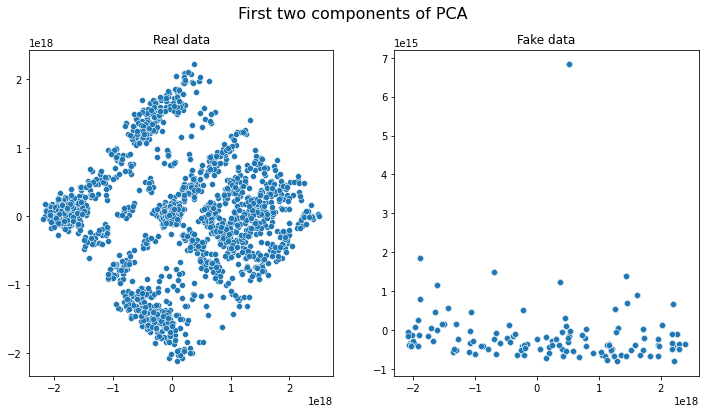

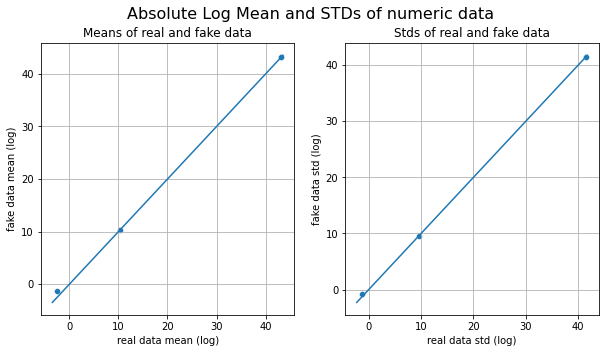

In [17]:
# Comparing the Orignal Data with Fake Data 
table_evaluator =  TableEvaluator(sample_diagnosis, dataframe_Diagnosis, cat_cols= cat_var_diagnosis)
table_evaluator.plot_pca()
table_evaluator.plot_mean_std()

In [18]:
sample_diagnosis = convert_cols_datetime(sample_diagnosis,sample_list) # transforming back the datetime values synthetic data
dataframe_Diagnosis = convert_cols_datetime(dataframe_Diagnosis,sample_list) # transforming back the datetime values synthetic data
sample_diagnosis.to_excel('Diagnosis_Fake.xlsx') # GeneratingFakeData into Excel

## Model 2 (Prescription Table)

In [19]:
# 2 Model
ctgan_model.fit(dataframe_Prescription,cat_var_prescription)
ctgan_model.save('Prescription_Sampler')

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Epoch 1, Loss G:  4.0397,Loss D: -0.1314
Epoch 2, Loss G:  3.8770,Loss D: -0.2258
Epoch 3, Loss G:  3.9073,Loss D: -0.2804
Epoch 4, Loss G:  3.8607,Loss D: -0.3612
Epoch 5, Loss G:  3.6325,Loss D: -0.2770
Epoch 6, Loss G:  3.8481,Loss D: -0.0843
Epoch 7, Loss G:  3.8424,Loss D: -0.0549
Epoch 8, Loss G:  3.4723,Loss D:  0.0909
Epoch 9, Loss G:  3.3968,Loss D: -0.0018
Epoch 10, Loss G:  3.3173,Loss D: -0.0408
Epoch 11, Loss G:  3.2407,Loss D:  0.0309
Epoch 12, Loss G:  3.3088,Loss D: -0.0548
Epoch 13, Loss G:  3.1095,Loss D:  0.0053
Epoch 14, Loss G:  3.0612,Loss D: -0.0768
Epoch 15, Loss G:  2.8768,Loss D:  0.0254
Epoch 16, Loss G:  2.8016,Loss D: -0.0397
Epoch 17, Loss G:  2.8120,Loss D: -0.0010
Epoch 18, Loss G:  2.5676,Loss D: -0.0503
Epoch 19, Loss G:  2.5727,Loss D:  0.0215
Epoch 20, Loss G:  2.6759,Loss D: -0.0430
Epoch 21, Loss G:  2.4628,Loss D: -0.0405
Epoch 22, Loss G:  2.3739,Loss D: -0.0009
Epoch 23, Loss G:  2.5554,Loss D: -0.0883
Epoch 24, Loss G:  2.1504,Loss D: -0.0988
E

In [20]:
sample_prescription = ctgan_model.sample(7046) # sampling same size of Input Data 
print('Orignal Dataset Shape {}'.format(dataframe_Prescription.shape), '', 'Fake Data Shape {}'.format(sample_prescription.shape))
print('----------------------------------------------------------------------------')
print(sample_prescription.info())

Orignal Dataset Shape (7046, 6)  Fake Data Shape (7046, 6)
----------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046 entries, 0 to 7045
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        7046 non-null   int64  
 1   drug              7046 non-null   object 
 2   drug_type         7046 non-null   object 
 3   Prescripton_date  7046 non-null   float64
 4   dose_val_rx       7046 non-null   object 
 5   dose_unit_rx      7046 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 330.4+ KB
None


In [21]:
table = TableEvaluator(dataframe_Prescription,sample_prescription,cat_cols=cat_var_prescription)

In [22]:
print('Correltaion Between Fake and Real Data Columns',table.column_correlations()) # represents the Pearson Correltaion in Columns between Fake and Real Data

Correltaion Between Fake and Real Data Columns 0.7874005931442594


In [23]:
table.evaluate(target_col='drug_type',verbose= True)


Correlation metric: pearsonr

Basic statistical attributes:
                                                                          real                                                 fake
mean_subject_id                                                    28,743.8534                                          28,481.2871
mean_Prescripton_date                           5,862,021,093,840,468,992.0000                       5,998,074,097,046,628,352.0000
median_subject_id                                                  40,310.0000                                          40,824.0000
median_Prescripton_date                         5,611,766,400,000,000,000.0000                       6,102,677,612,813,212,672.0000
std_subject_id                                                     15,788.3086                                          15,724.2942
std_Prescripton_date                              980,149,661,310,123,648.0000                         748,326,418,405,716,480.0000
variance_subjec

{'1 - MAPE Estimator results': 0.9779685925429227,
 'Basic statistics': 0.9761904761904763,
 'Correlation column correlations': 0.8871482055357459,
 'Mean Correlation between fake and real columns': 0.7874005931442594,
 'Similarity Score': 0.9071769668533511}

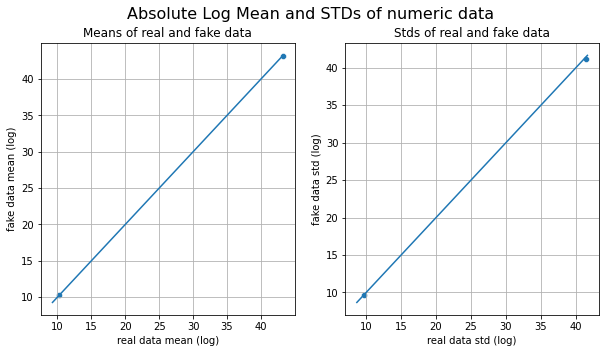

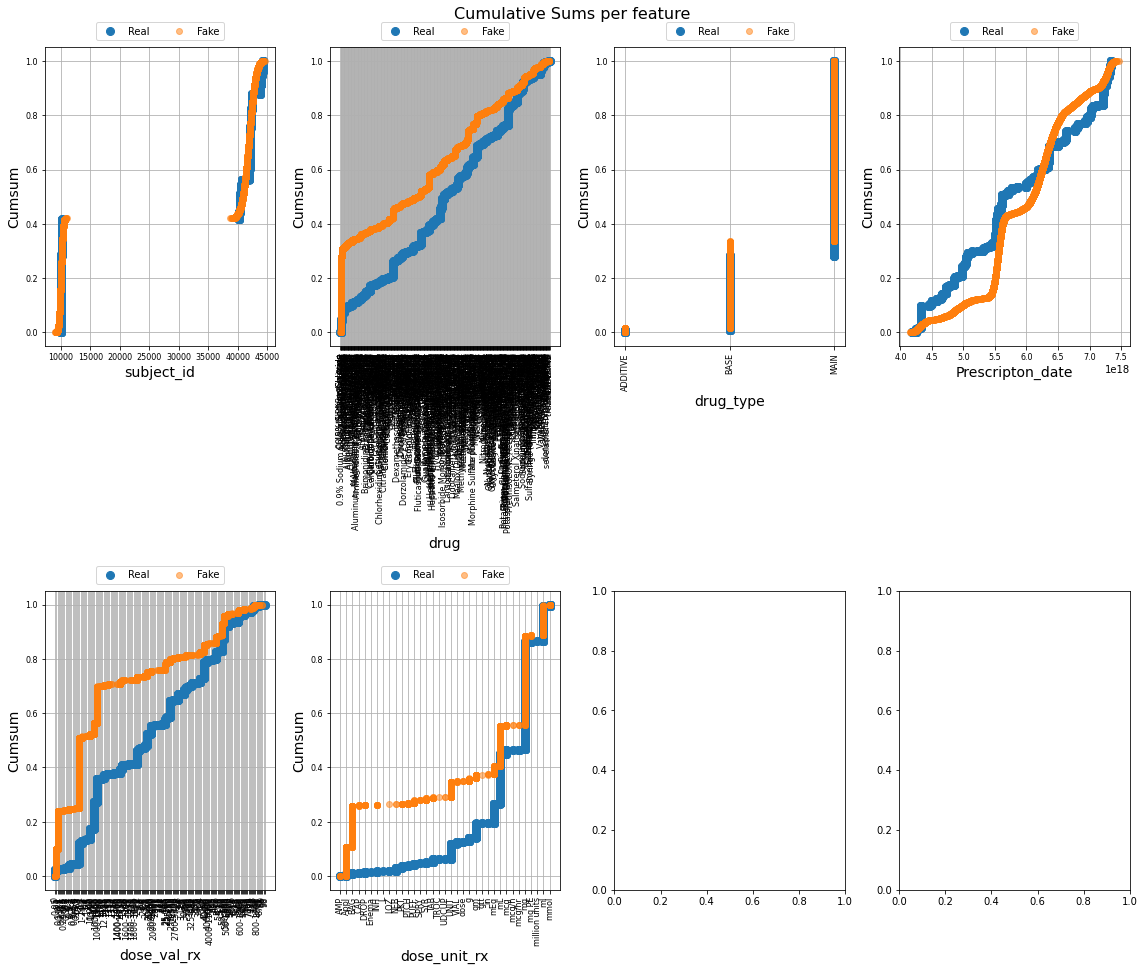

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

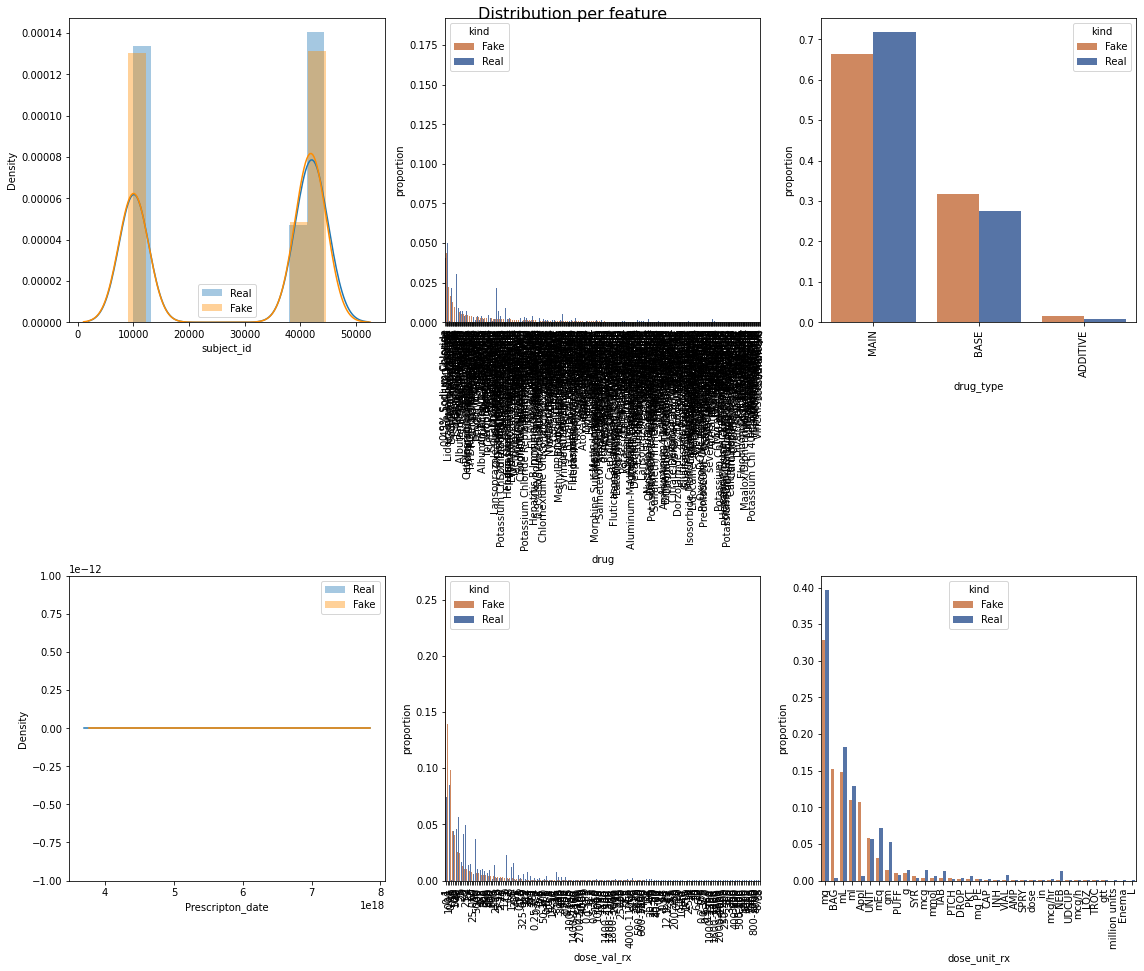

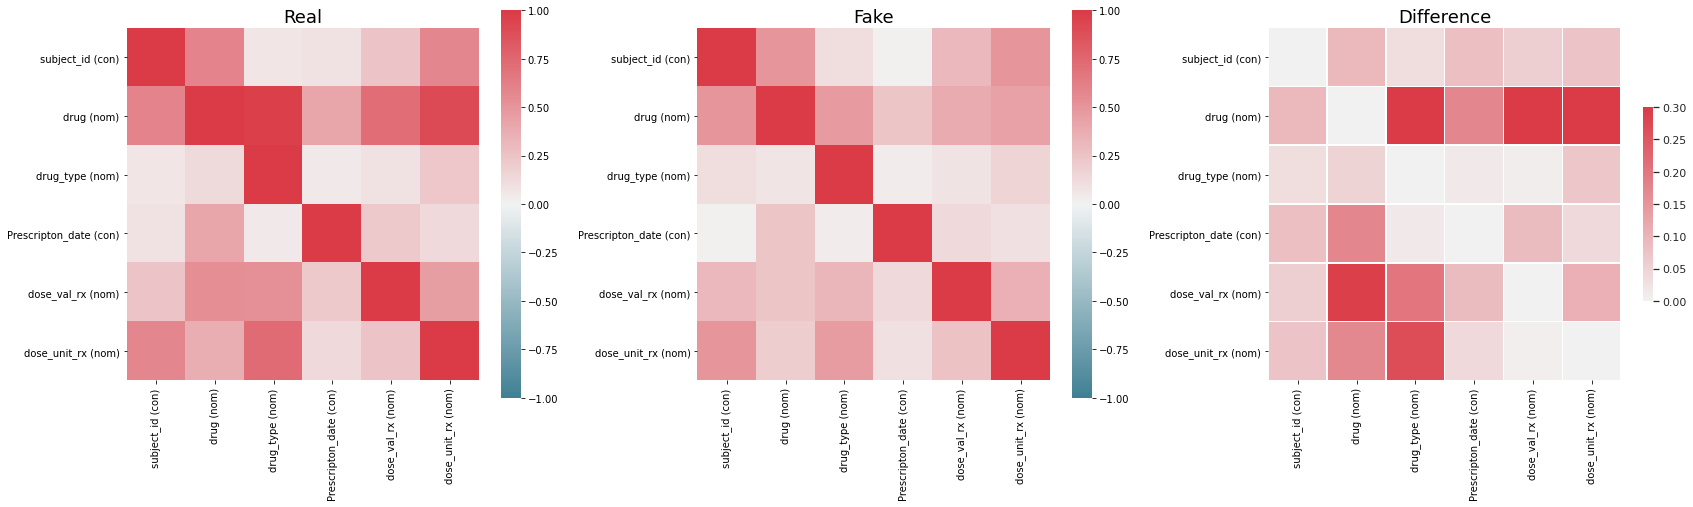

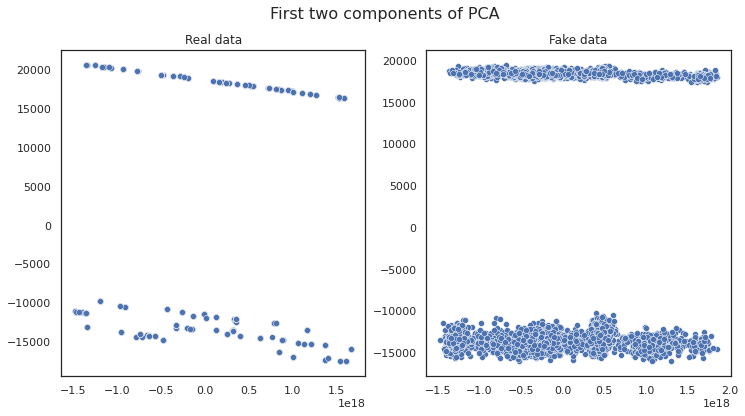

In [24]:
table.visual_evaluation() # All Possible Visual Evaluation Betwee Fake and Real Data

In [25]:
sample_prescription = convert_cols_datetime(sample_prescription,sample_list)
dataframe_Prescription = convert_cols_datetime(dataframe_Prescription,sample_list)
sample_prescription.to_excel('Prescriptions_Fake.xlsx')

## Model 3 (Vital Signs)

In [46]:
# 3 Model
ctgan_model.fit(dataframe_Vital_Signs,cat_var_vital,epochs=400)
ctgan_model.save('Vital_Sign_Sampler')

Epoch 1, Loss G:  1.5434,Loss D:  0.1449
Epoch 2, Loss G:  0.6604,Loss D: -0.0817
Epoch 3, Loss G:  0.0479,Loss D: -0.1386
Epoch 4, Loss G: -0.3745,Loss D: -0.2006
Epoch 5, Loss G: -0.1004,Loss D: -0.3058
Epoch 6, Loss G: -0.1373,Loss D: -0.1885
Epoch 7, Loss G: -0.1640,Loss D: -0.3212
Epoch 8, Loss G: -0.1691,Loss D: -0.2740
Epoch 9, Loss G: -0.2519,Loss D: -0.1941
Epoch 10, Loss G: -0.3815,Loss D: -0.0510
Epoch 11, Loss G: -0.4533,Loss D: -0.0796
Epoch 12, Loss G: -0.5992,Loss D:  0.0969
Epoch 13, Loss G: -0.4374,Loss D: -0.0964
Epoch 14, Loss G: -0.6675,Loss D: -0.0539
Epoch 15, Loss G: -0.5599,Loss D: -0.0752
Epoch 16, Loss G: -0.5197,Loss D: -0.1020
Epoch 17, Loss G: -0.7102,Loss D:  0.0796
Epoch 18, Loss G: -0.6424,Loss D:  0.0418
Epoch 19, Loss G: -0.6254,Loss D: -0.0407
Epoch 20, Loss G: -0.6302,Loss D: -0.0929
Epoch 21, Loss G: -0.6084,Loss D:  0.0345
Epoch 22, Loss G: -0.4649,Loss D:  0.0694
Epoch 23, Loss G: -0.6440,Loss D: -0.1547
Epoch 24, Loss G: -0.6599,Loss D: -0.0612
E

In [47]:
sample_vital_signs = ctgan_model.sample(50890)
print('Orignal Dataset Shape {}'.format(dataframe_Vital_Signs.shape), '', 'Fake Data Shape {}'.format(sample_vital_signs.shape))
print('--------------------------------------------------')

Orignal Dataset Shape (50890, 5)  Fake Data Shape (50890, 5)
--------------------------------------------------


In [48]:
 x = TableEvaluator(dataframe_Vital_Signs, sample_vital_signs, cat_cols=cat_var_vital)

In [ ]:
x.evaluate('label')

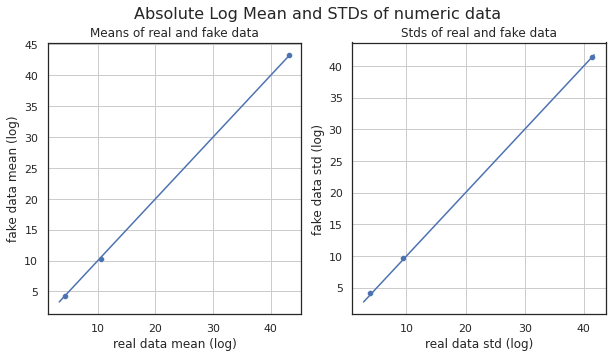

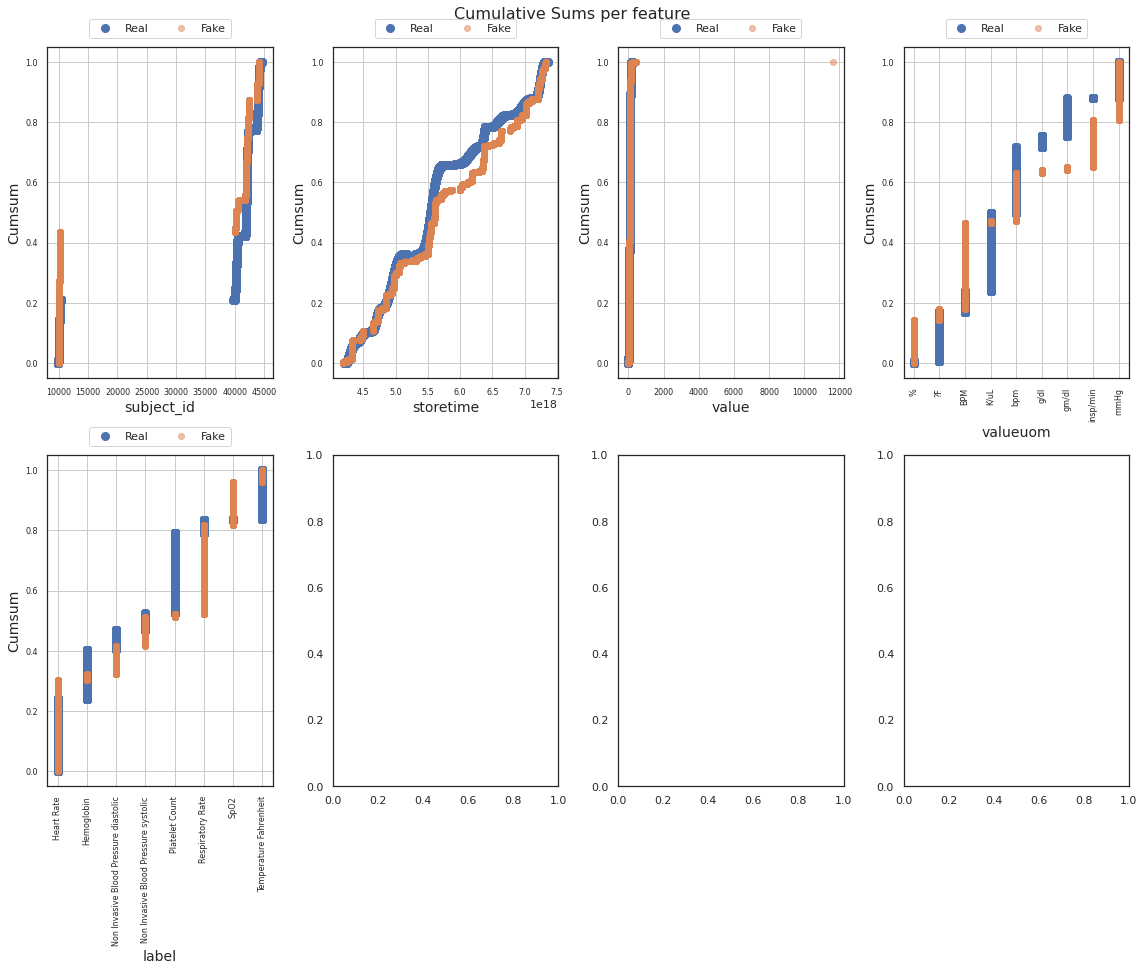

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

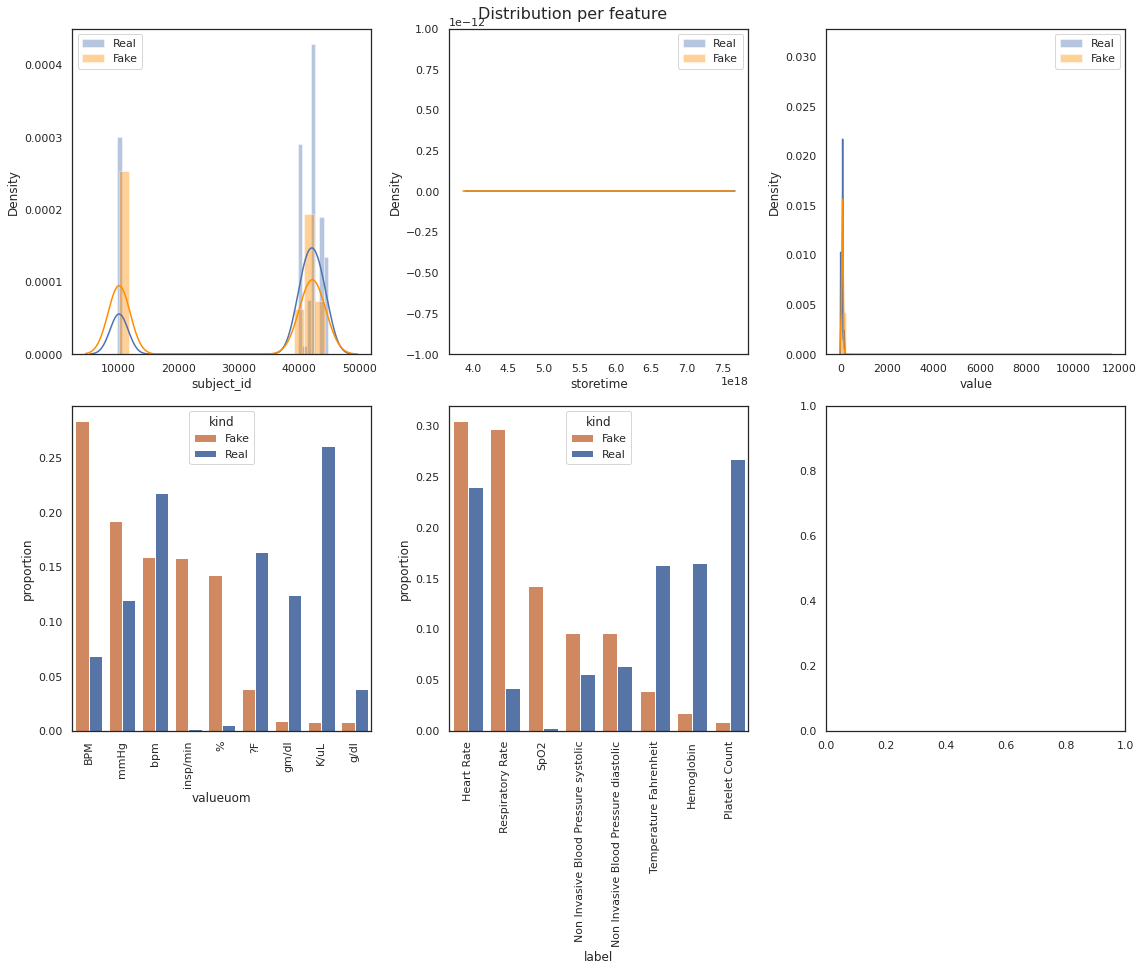

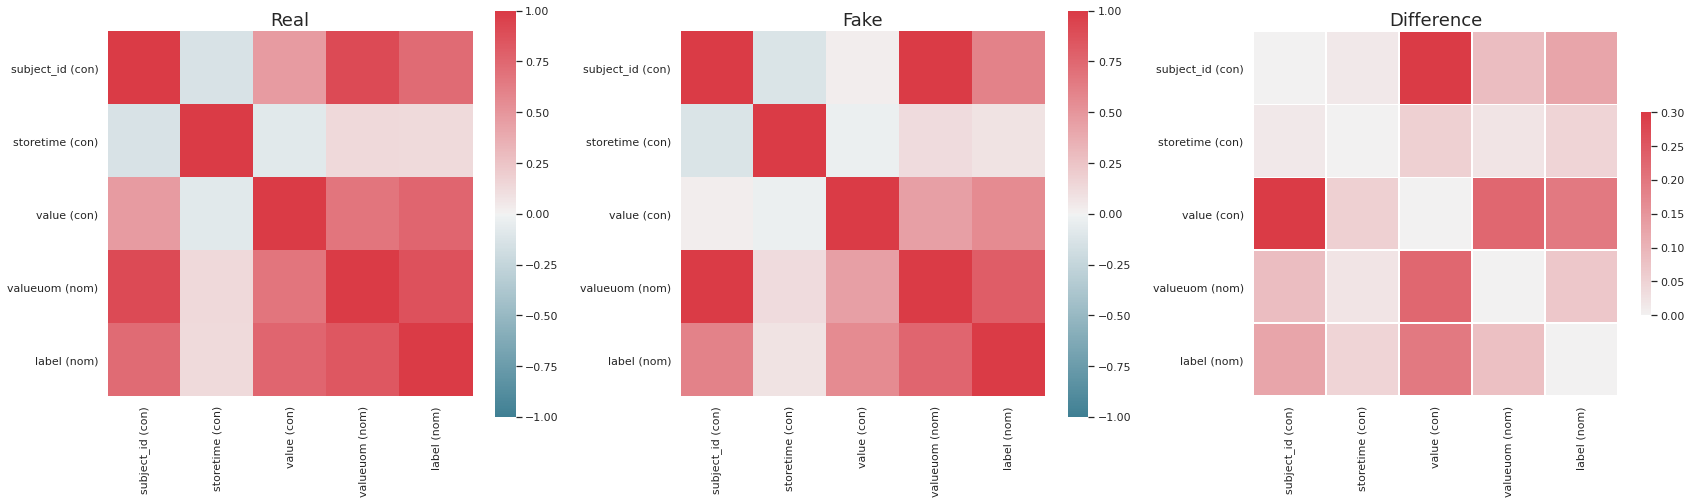

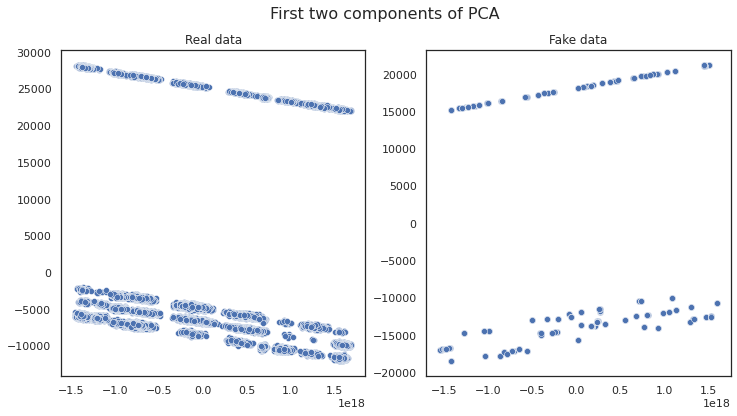

In [49]:
table_evaluator =  TableEvaluator(sample_vital_signs, dataframe_Vital_Signs, cat_cols= cat_var_vital)
table_evaluator.visual_evaluation()

In [50]:
sample_vital_signs = convert_cols_datetime(sample_vital_signs,sample_list)
dataframe_Vital_Signs = convert_cols_datetime(dataframe_Vital_Signs,sample_list)
sample_vital_signs.to_excel('Vital_Sign_Fake.xlsx')

In [51]:
sample_vital_signs.sample(5)

,subject_id,storetime,value,valueuom,label
26741,42107,May-01-2198 08:19 PM,107.9185,bpm,Heart Rate
39942,42276,July-20-2168 03:29 PM,68.1193,K/uL,Platelet Count
46548,42171,November-02-2119 02:26 PM,65.4778,K/uL,Platelet Count
43420,40455,January-03-2147 12:24 AM,157.8221,mmHg,Non Invasive Blood Pressure systolic
19285,42065,September-16-2129 11:29 AM,86.7114,K/uL,Platelet Count


In [52]:
dataframe_Vital_Signs.sample(5)

,subject_id,storetime,value,valueuom,label
20881,10126,August-13-2171 04:06 AM,100.0000,%,SpO2
14114,10127,July-08-2198 08:45 AM,12.0000,BPM,Respiratory Rate
9602,10061,January-23-2107 03:00 PM,16.0000,BPM,Respiratory Rate
24345,41914,December-14-2145 10:15 AM,117.0000,bpm,Heart Rate
19594,10124,May-10-2192 10:19 AM,97.0000,%,SpO2


In [35]:
%matplotlib inline

In [36]:
sample_vital_signs.label.value_counts()

Platelet Count                           13765
Heart Rate                               11818
Hemoglobin                                8539
Temperature Fahrenheit                    8445
Non Invasive Blood Pressure systolic      3288
Non Invasive Blood Pressure diastolic     2927
Respiratory Rate                          1941
SpO2                                       167
Name: label, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0169c8f668>,
      dtype=object)

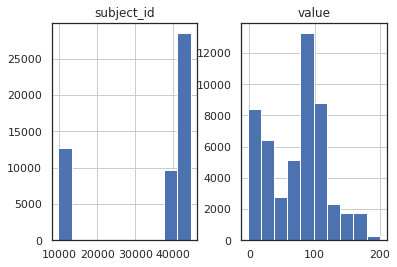

In [37]:
sample_vital_signs.hist()

In [38]:
dataframe_Vital_Signs.label.count()

50890

## Moel 4 ( Therapy) 

In [39]:
#4 Model
ctgan_model.fit(dataframe_Therapy,cat_var_Therapy)
ctgan_model.save('Therapy_Sampler')

Epoch 1, Loss G:  4.0870,Loss D: -0.1507
Epoch 2, Loss G:  3.8529,Loss D: -0.2724
Epoch 3, Loss G:  3.8692,Loss D: -0.2594
Epoch 4, Loss G:  3.7561,Loss D: -0.2250
Epoch 5, Loss G:  3.7387,Loss D: -0.2742
Epoch 6, Loss G:  3.5569,Loss D: -0.1085
Epoch 7, Loss G:  3.6145,Loss D: -0.1582
Epoch 8, Loss G:  3.5591,Loss D: -0.0132
Epoch 9, Loss G:  3.3879,Loss D:  0.0003
Epoch 10, Loss G:  3.2384,Loss D: -0.0420
Epoch 11, Loss G:  3.1473,Loss D:  0.0108
Epoch 12, Loss G:  2.8315,Loss D:  0.0434
Epoch 13, Loss G:  3.2104,Loss D: -0.0248
Epoch 14, Loss G:  3.0478,Loss D: -0.0119
Epoch 15, Loss G:  3.0705,Loss D: -0.0202
Epoch 16, Loss G:  2.8198,Loss D: -0.0406
Epoch 17, Loss G:  2.5597,Loss D:  0.0214
Epoch 18, Loss G:  2.7145,Loss D: -0.1165
Epoch 19, Loss G:  2.7812,Loss D:  0.0522
Epoch 20, Loss G:  2.7303,Loss D: -0.0542
Epoch 21, Loss G:  2.4048,Loss D:  0.0366
Epoch 22, Loss G:  2.4374,Loss D: -0.1167
Epoch 23, Loss G:  2.2298,Loss D:  0.0856
Epoch 24, Loss G:  2.2775,Loss D: -0.1204
E

In [40]:
sample_Therapy = ctgan_model.sample(1000)
print('Orignal Dataset Shape {}'.format(dataframe_Therapy.shape), '', 'Fake Data Shape {}'.format(sample_Therapy.shape))
print('----------------------------------------------------------------------------')
print('Correlation with Orignal Dataset: {}'.format(dataframe_Therapy.corrwith(sample_Therapy, axis = 0)))

Orignal Dataset Shape (7046, 6)  Fake Data Shape (1000, 6)
----------------------------------------------------------------------------
Correlation with Orignal Dataset: subject_id         -0.0047
Prescripton_date    0.0461
dtype: float64


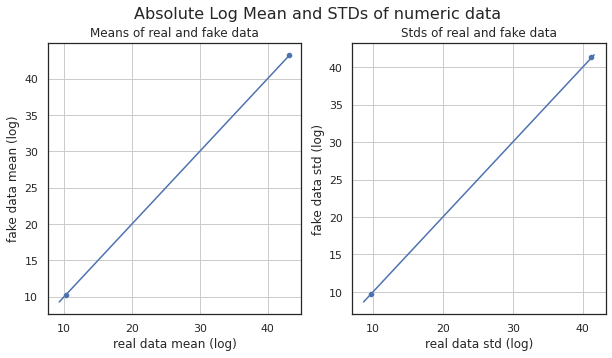

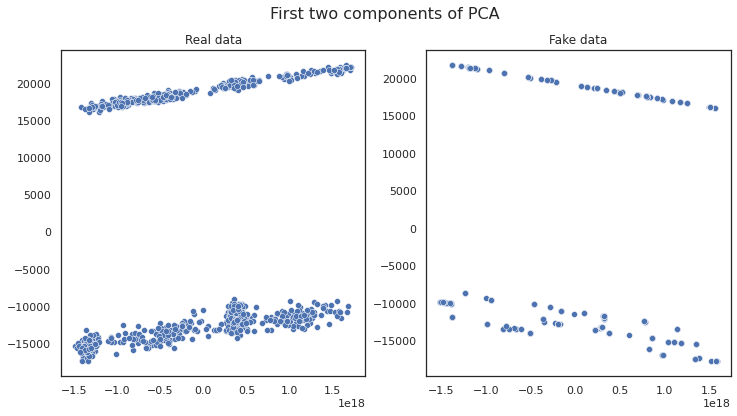

In [41]:
table_evaluator =  TableEvaluator(sample_Therapy, dataframe_Therapy, cat_cols= cat_var_Therapy)
table_evaluator.plot_mean_std()
table_evaluator.plot_pca()

In [42]:
sample_Therapy = convert_cols_datetime(sample_Therapy,sample_list)
sample_Therapy.to_excel('Therapy_Fake.xlsx')